### Run, train and validate models

Pre-process the data, train and validate models using AUC as the performance metric

In [1]:
import pandas as pd
import numpy as np
import argparse
import os
import json
import tarfile
import s3fs
import pickle

!pip install xgboost
import xgboost

from sklearn.model_selection import train_test_split

import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.sklearn.estimator import SKLearn
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.s3 import S3Downloader
from sagemaker.tuner import (
    IntegerParameter,
    ContinuousParameter,
    CategoricalParameter,
    HyperparameterTuner,
)
from sagemaker.amazon.amazon_estimator import get_image_uri
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

import XGBoost_eval
import SKLearn_input_prep
import plot_hyperparameter_tuning as plt_hyper

sklearn_v = "0.20.0"
role = get_execution_role()
session = sagemaker.Session()

In [2]:
# create a list of the features to use for modeling

feat_list = [
    "CUST_PRICE_SENSITIVITY",
    "CUST_LIFESTAGE",
    "BASKET_SIZE_PROP_SPEND_PROD_CODE_M",
    "BASKET_PRICE_SENSITIVITY_SPEND_CUST_CODE_LA",
    "DAY_PART_PROP_SPEND_CUST_CODE_AFTERNOON",
    "BASKET_SIZE_PROP_VISITS_CUST_CODE_L",
    "BASKET_DOMINANT_MISSION_PROP_SPEND_PROD_CODE_Fresh",
    "BASKET_TYPE_PROP_VISITS_CUST_CODE_Small Shop",
    "BASKET_SIZE_PROP_QUANTITY_PROD_CODE_L",
    "STORE_FORMAT_PROP_VISITS_CUST_CODE_MS",
    "CHNG_VISITS_PROD_CODE_30_1_52",
    "STORE_FORMAT_PROP_SPEND_PROD_CODE_LS",
    "STORE_FORMAT_PROP_QUANTITY_CUST_CODE_SS",
    "BASKET_SIZE_QUANTITY_CUST_CODE_S",
    "BASKET_DOMINANT_MISSION_PROP_QUANTITY_PROD_CODE_Nonfood",
    "CHNG_SPEND_PROD_CODE_40_8_52",
    "BASKET_DOMINANT_MISSION_PROP_VISITS_CUST_CODE_XX",
    "BASKET_TYPE_VISITS_CUST_CODE_XX",
    "WKDAY_WKEND_PROP_QUANTITY_CUST_CODE_WEEKEND",
    "BASKET_TYPE_QUANTITY_CUST_CODE_Small Shop",
    "SPEND_PROD_CODE_30_52",
    "BASKET_TYPE_SPEND_CUST_CODE_Top Up",
    "BASKET_DOMINANT_MISSION_PROP_SPEND_CUST_CODE_Grocery",
    "CHNG_QUANTITY_PROD_CODE_40_26_52",
    "SPEND_PROD_CODE_20_52",
    "BASKET_TYPE_PROP_QUANTITY_CUST_CODE_Top Up",
    "VISITS_PROD_CODE_20_52",
    "WKDAY_WKEND_PROP_VISITS_PROD_CODE_WEEKEND",
    "VISITS_PROD_CODE_40_1",
    "CHNG_VISITS_PROD_CODE_40_1_26",
    "BASKET_TYPE_PROP_SPEND_PROD_CODE_XX",
    "STORE_FORMAT_PROP_VISITS_CUST_CODE_XLS",
    "DAY_PART_PROP_VISITS_CUST_CODE_EVENING",
    "TIME_BTWN_MEDIAN_OVERALL_PROD_CODE_40",
    "STORE_FORMAT_PROP_VISITS_PROD_CODE_XLS",
    "DAY_PART_PROP_SPEND_PROD_CODE_MORNING",
    "STORE_FORMAT_PROP_SPEND_PROD_CODE_SS",
    "STORE_FORMAT_PROP_VISITS_PROD_CODE_MS",
    "DAY_PART_PROP_SPEND_CUST_CODE_MORNING",
    "BASKET_PRICE_SENSITIVITY_PROP_SPEND_PROD_CODE_LA",
    "DAY_PART_PROP_QUANTITY_PROD_CODE_EVENING",
    "BASKET_PRICE_SENSITIVITY_SPEND_CUST_CODE_UM",
    "BASKET_DOMINANT_MISSION_PROP_SPEND_PROD_CODE_Grocery",
    "BASKET_PRICE_SENSITIVITY_PROP_QUANTITY_PROD_CODE_MM",
    "STORE_FORMAT_PROP_SPEND_CUST_CODE_LS",
    "QUANTITY_PROD_CODE_52",
    "BASKET_TYPE_PROP_VISITS_PROD_CODE_Top Up",
    "DAY_PART_PROP_SPEND_PROD_CODE_AFTERNOON",
    "CHNG_VISITS_PROD_CODE_20_1_8",
    "BASKET_PRICE_SENSITIVITY_PROP_QUANTITY_CUST_CODE_MM",
    "BASKET_DOMINANT_MISSION_SPEND_CUST_CODE_XX",
    "USER_factor_0",
    "USER_factor_1",
    "USER_factor_2",
    "USER_factor_3",
    "USER_factor_4",
    "ITEM_factor_0",
    "ITEM_factor_1",
    "ITEM_factor_2",
    "ITEM_factor_3",
    "ITEM_factor_4",
]

In [3]:
sklearn_processor = SKLearnProcessor(
    framework_version=sklearn_v,
    role=role,
    instance_type="ml.m5.xlarge",
    instance_count=1,
)

### Pre-process the data

In [4]:
# Keep only the specified features from the training and test sets that will be used for model developement
input_data_train, input_data_test = SKLearn_input_prep.create_model_input(
    bucket="udacity-machine-learning-capstone-data",
    train_key="train_df_features.csv",
    test_key="test_df_features.csv",
    out_file_train="train_df_final_features.csv",
    out_file_test="test_df_final_features.csv",
    feat_list=feat_list,
)

# Run the pre-processing steps by calling preprocessing.py
sklearn_processor.run(
    code="preprocessing.py",
    inputs=[
        ProcessingInput(
            source=input_data_train, destination="/opt/ml/processing/input_data_train"
        ),
        ProcessingInput(
            source=input_data_test, destination="/opt/ml/processing/input_data_test"
        ),
    ],
    outputs=[
        ProcessingOutput(output_name="train_data", source="/opt/ml/processing/train"),
        ProcessingOutput(output_name="test_data", source="/opt/ml/processing/test"),
        ProcessingOutput(output_name="valid_data", source="/opt/ml/processing/valid"),
    ],
    arguments=["--train-test-split-ratio", "0.2"],
)

preprocessing_job_description = sklearn_processor.jobs[-1].describe()

output_config = preprocessing_job_description["ProcessingOutputConfig"]
for output in output_config["Outputs"]:
    if output["OutputName"] == "train_data":
        preprocessed_training_data = output["S3Output"]["S3Uri"]
    if output["OutputName"] == "test_data":
        preprocessed_test_data = output["S3Output"]["S3Uri"]
    if output["OutputName"] == "valid_data":
        preprocessed_valid_data = output["S3Output"]["S3Uri"]


Job Name:  sagemaker-scikit-learn-2020-03-22-23-24-37-718
Inputs:  [{'InputName': 'input-1', 'S3Input': {'S3Uri': 's3://udacity-machine-learning-capstone-data/train_df_final_features.csv', 'LocalPath': '/opt/ml/processing/input_data_train', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'input-2', 'S3Input': {'S3Uri': 's3://udacity-machine-learning-capstone-data/test_df_final_features.csv', 'LocalPath': '/opt/ml/processing/input_data_test', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'S3Input': {'S3Uri': 's3://sagemaker-us-east-2-800613416076/sagemaker-scikit-learn-2020-03-22-23-24-37-718/input/code/preprocessing.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs

### Train, tune and evaluate Logistic Regression model

#### Tune the hyperparameters

In [11]:
# Set up the logistic model
logistic_model = SKLearn(
    entry_point="train_logistic.py",
    train_instance_type="ml.m5.xlarge",
    hyperparameters={"reg_param": 0.01, "tune": 1},
    role=role,
)

# Set up the hyperparameter tuning job
logistic_hyperparameter_tuner = HyperparameterTuner(
    estimator=logistic_model,
    objective_metric_name="AUC",
    objective_type="Maximize",
    metric_definitions=[{"Name": "AUC", "Regex": "ROC AUC: ([0-9\\.]+)"}],
    max_jobs=20,
    max_parallel_jobs=3,
    hyperparameter_ranges={"reg_param": ContinuousParameter(0, 10)},
)

# Run the hyperparameter tuning job
logistic_hyperparameter_tuner.fit(
    {"train": preprocessed_training_data, "test": preprocessed_test_data}
)
logistic_hyperparameter_tuner.wait()
logistic_hyperparameter_tuner.best_training_job()

# Get analysis on the tuning job including best hyperparameters
tuning_analysis = (
    logistic_hyperparameter_tuner.analytics()
    .dataframe()
    .sort_values(by=["TrainingStartTime"], ascending=False, axis=0)
)
tuning_analysis['iteration'] = tuning_analysis.index
tuning_analysis.sort_values(by=["FinalObjectiveValue"], ascending=False, axis=0, inplace=True)

.................................................................................................................................................................................................................................................!


In [12]:
tuning_analysis

,FinalObjectiveValue,TrainingElapsedTimeSeconds,TrainingEndTime,TrainingJobName,TrainingJobStatus,TrainingStartTime,reg_param,iteration
19,0.88798,39.0,2020-02-09 02:40:32+00:00,sagemaker-scikit-lea-200209-0238-001-0cd4ee14,Completed,2020-02-09 02:39:53+00:00,8.316668,19
18,0.88798,38.0,2020-02-09 02:40:33+00:00,sagemaker-scikit-lea-200209-0238-002-b0373c14,Completed,2020-02-09 02:39:55+00:00,5.184062,18
3,0.88798,44.0,2020-02-09 02:55:03+00:00,sagemaker-scikit-lea-200209-0238-017-d3466c48,Completed,2020-02-09 02:54:19+00:00,8.936480,3
4,0.88798,39.0,2020-02-09 02:54:45+00:00,sagemaker-scikit-lea-200209-0238-016-188c0223,Completed,2020-02-09 02:54:06+00:00,9.069842,4
14,0.88798,37.0,2020-02-09 02:44:01+00:00,sagemaker-scikit-lea-200209-0238-006-5e8157e3,Completed,2020-02-09 02:43:24+00:00,9.932879,14
11,0.88798,42.0,2020-02-09 02:47:12+00:00,sagemaker-scikit-lea-200209-0238-009-5d06e6a4,Completed,2020-02-09 02:46:30+00:00,9.959430,11
9,0.88797,38.0,2020-02-09 02:49:42+00:00,sagemaker-scikit-lea-200209-0238-011-c329f3b8,Completed,2020-02-09 02:49:04+00:00,3.038348,9
13,0.88797,39.0,2020-02-09 02:46:15+00:00,sagemaker-scikit-lea-200209-0238-007-ce06a89e,Completed,2020-02-09 02:45:36+00:00,6.878070,13
10,0.88797,38.0,2020-02-09 02:49:15+00:00,sagemaker-scikit-lea-200209-0238-010-30ca28bc,Completed,2020-02-09 02:48:37+00:00,2.746295,10
8,0.88797,37.0,2020-02-09 02:49:49+00:00,sagemaker-scikit-lea-200209-0238-012-7a7f5560,Completed,2020-02-09 02:49:12+00:00,4.038714,8


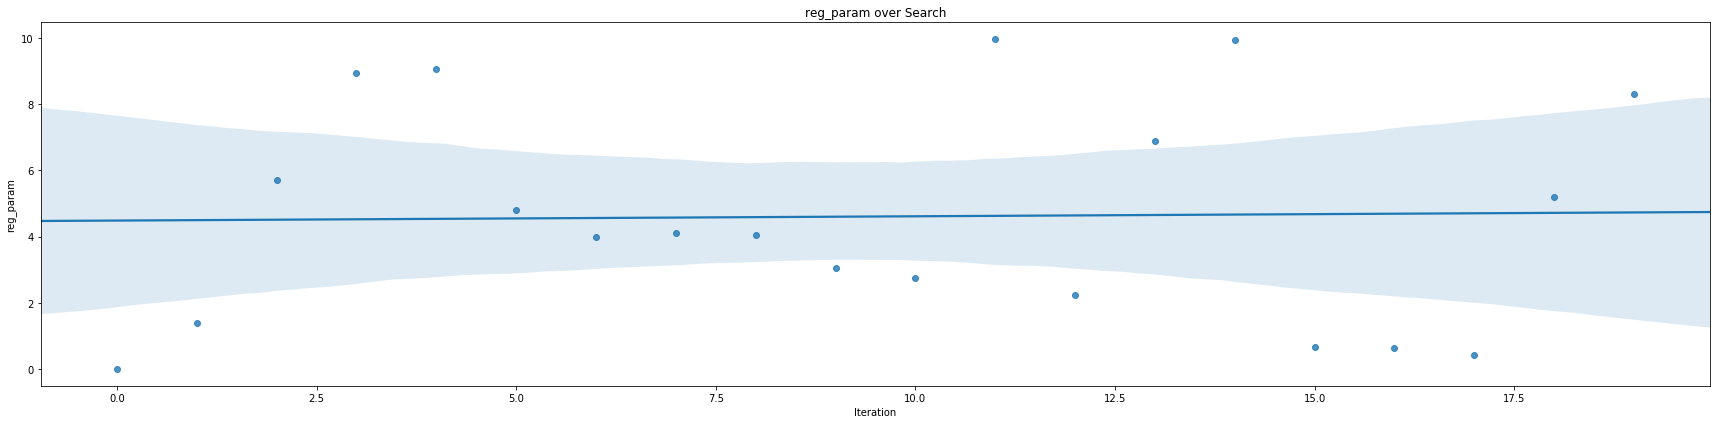

In [13]:
# Plot the value of hyperparameters over the tuning window
plt_hyper.plot_hyperparams_over_search(df=tuning_analysis, hyperparams=["reg_param"])

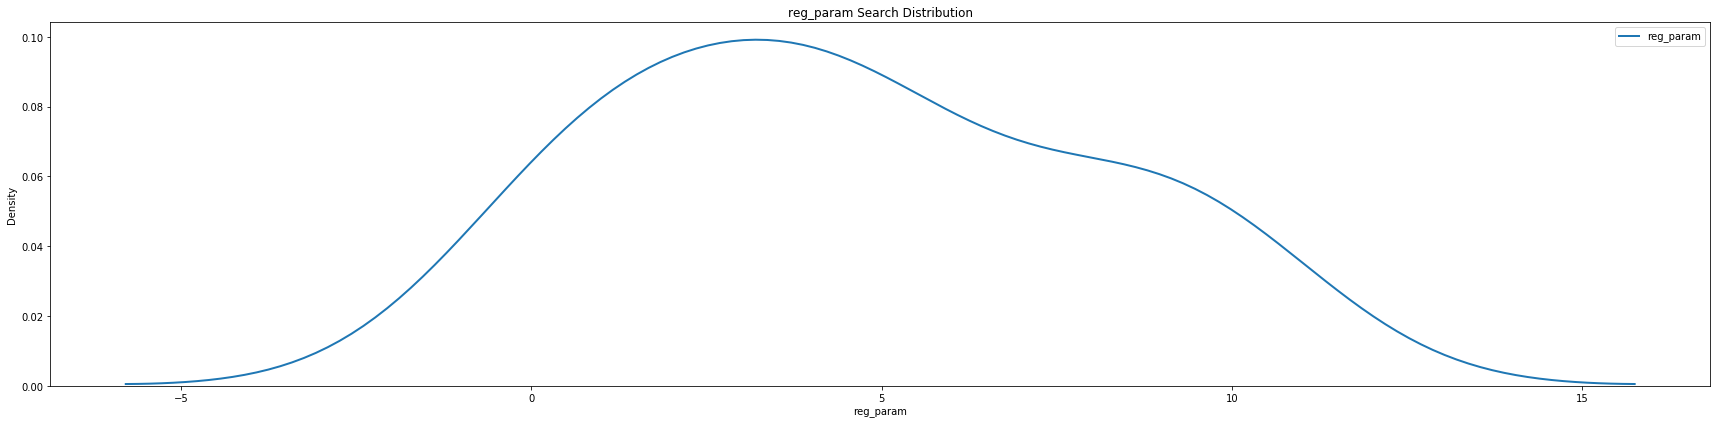

In [15]:
# Create a kde plot of hyperparameters used over the tuning window
plt_hyper.plot_search_dist(df=tuning_analysis, hyperparams=["reg_param"])

In [16]:
# Get the best hyperparameters and refit the model over the training data with the best params
tuning_analysis.sort_values(by=["FinalObjectiveValue"], ascending=False, axis=0, inplace=True)
reg_param = tuning_analysis["reg_param"].reset_index(drop=True)[0]

logistic_model = SKLearn(
    entry_point="train_logistic.py",
    train_instance_type="ml.m5.xlarge",
    hyperparameters={"reg_param": reg_param, "tune": 0},
    role=role,
)

logistic_model.fit({"train": preprocessed_training_data})
training_job_description = logistic_model.jobs[-1].describe()
model_data_s3_uri = "{}{}/{}".format(
    training_job_description["OutputDataConfig"]["S3OutputPath"],
    training_job_description["TrainingJobName"],
    "output/model.tar.gz",
)

# Run the evaluation on the validation set
sklearn_processor.run(
    code="evaluation_sklearn.py",
    inputs=[
        ProcessingInput(
            source=model_data_s3_uri, destination="/opt/ml/processing/model"
        ),
        ProcessingInput(
            source=preprocessed_valid_data, destination="/opt/ml/processing/valid"
        ),
    ],
    outputs=[
        ProcessingOutput(
            output_name="evaluation", source="/opt/ml/processing/evaluation"
        )
    ],
)
evaluation_job_description = sklearn_processor.jobs[-1].describe()

evaluation_output_config = evaluation_job_description["ProcessingOutputConfig"]
for output in evaluation_output_config["Outputs"]:
    if output["OutputName"] == "evaluation":
        evaluation_s3_uri = output["S3Output"]["S3Uri"] + "/evaluation.json"
        break

evaluation_output = S3Downloader.read_file(evaluation_s3_uri)
evaluation_output_dict = json.loads(evaluation_output)
print(json.dumps(evaluation_output_dict, sort_keys=True, indent=4))

2020-02-09 03:01:53 Starting - Starting the training job...
2020-02-09 03:01:55 Starting - Launching requested ML instances......
2020-02-09 03:02:56 Starting - Preparing the instances for training...
2020-02-09 03:03:43 Downloading - Downloading input data
2020-02-09 03:03:43 Training - Downloading the training image..2020-02-09 03:03:56,367 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2020-02-09 03:03:56,370 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-02-09 03:03:56,379 sagemaker_sklearn_container.training INFO     Invoking user training script.
2020-02-09 03:03:56,602 sagemaker-containers INFO     Module train_logistic does not provide a setup.py. 
Generating setup.py
2020-02-09 03:03:56,602 sagemaker-containers INFO     Generating setup.cfg
2020-02-09 03:03:56,602 sagemaker-containers INFO     Generating MANIFEST.in
2020-02-09 03:03:56,603 sagemaker-containers INFO     Installing module with the followin

..................
/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/cloudpickle/cloudpickle.py:47: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
Extracting model from path: /opt/ml/processing/model/model.tar.gz
Loading model
Loading validation input data
Creating classification evaluation report
Classification report:
{'0.0': {'precision': 0.8015475085112969, 'recall': 0.8901491716505121, 'f1-score': 0.8435281089179858, 'support': 14547}, '1.0': {'precision': 0.8765355790774936, 'recall': 0.7796715002405333, 'f1-score': 0.825270968211246, 'support': 14551}, 'micro avg': {'precision': 0.8349027424565262, 'recall': 0.8349027424565262, 'f1-score': 0.8349027424565262, 'support': 29098}, 'macro avg': {'precision': 0.8390415437943952, 'recall': 0.8349103359455228, 'f1-score': 0.8343995385646159, 'support': 29098}, 'weighted avg': {'precision': 0.8390466979679169, 'recall': 0.

### Train, tune and evaluate Random Forest model

#### Tune the hyperparamters

In [45]:
# Set up the Random Forest model
rf_model = SKLearn(
    entry_point="train_rf.py",
    train_instance_type="ml.m5.xlarge",
    hyperparameters={
        "n_estimators": 500,
        "max_features": "auto",
        "max_depth": 5,
        "tune": 1,
    },
    role=role,
)

# Set up the hyperparameter tuning job for the Random Forest model
rf_hyperparameter_tuner = HyperparameterTuner(
    estimator=rf_model,
    objective_metric_name="AUC",
    objective_type="Maximize",
    metric_definitions=[{"Name": "AUC", "Regex": "ROC AUC RF: ([0-9\\.]+)"}],
    max_jobs=20,
    max_parallel_jobs=3,
    hyperparameter_ranges={
        "max_depth": IntegerParameter(3, 12),
        "n_estimators": IntegerParameter(50, 1000),
        "max_features": CategoricalParameter(["auto", "sqrt", "log2"]),
    },
)

rf_hyperparameter_tuner.fit(
    {"train": preprocessed_training_data, "test": preprocessed_test_data}
)
rf_hyperparameter_tuner.wait()
rf_hyperparameter_tuner.best_training_job()

# Get analysis on the tuning job including best hyperparameters
tuning_analysis = (
    rf_hyperparameter_tuner.analytics()
    .dataframe()
    .sort_values(by=["TrainingStartTime"], ascending=False, axis=0)
)

tuning_analysis.loc[:, "max_features"] = tuning_analysis.loc[
    :, "max_features"
].str.replace('"', "")

tuning_analysis['iteration'] = tuning_analysis.index
tuning_analysis.sort_values(by=["FinalObjectiveValue"], ascending=False, axis=0, inplace=True)

..................................................................................................................................................................................................................................................!


In [46]:
tuning_analysis

,FinalObjectiveValue,TrainingElapsedTimeSeconds,TrainingEndTime,TrainingJobName,TrainingJobStatus,TrainingStartTime,max_depth,max_features,n_estimators,iteration
7,0.97533,53.0,2020-03-23 01:05:39+00:00,sagemaker-scikit-lea-200323-0051-013-63f89bce,Completed,2020-03-23 01:04:46+00:00,12.0,log2,236.0,7
11,0.97528,47.0,2020-03-23 01:00:01+00:00,sagemaker-scikit-lea-200323-0051-009-06fdfe5e,Completed,2020-03-23 00:59:14+00:00,12.0,log2,252.0,11
2,0.97524,68.0,2020-03-23 01:09:35+00:00,sagemaker-scikit-lea-200323-0051-018-2f8f27db,Completed,2020-03-23 01:08:27+00:00,12.0,log2,735.0,2
3,0.97522,69.0,2020-03-23 01:08:43+00:00,sagemaker-scikit-lea-200323-0051-017-2b18956f,Completed,2020-03-23 01:07:34+00:00,12.0,log2,737.0,3
5,0.97521,67.0,2020-03-23 01:06:28+00:00,sagemaker-scikit-lea-200323-0051-015-180cbcb5,Completed,2020-03-23 01:05:21+00:00,12.0,log2,994.0,5
4,0.97516,69.0,2020-03-23 01:09:06+00:00,sagemaker-scikit-lea-200323-0051-016-689612cf,Completed,2020-03-23 01:07:57+00:00,12.0,log2,812.0,4
6,0.97514,45.0,2020-03-23 01:05:32+00:00,sagemaker-scikit-lea-200323-0051-014-b9ba2412,Completed,2020-03-23 01:04:47+00:00,12.0,log2,207.0,6
1,0.97514,69.0,2020-03-23 01:11:42+00:00,sagemaker-scikit-lea-200323-0051-019-196ccf71,Completed,2020-03-23 01:10:33+00:00,12.0,log2,883.0,1
0,0.97513,58.0,2020-03-23 01:11:51+00:00,sagemaker-scikit-lea-200323-0051-020-a75b4d49,Completed,2020-03-23 01:10:53+00:00,12.0,log2,506.0,0
12,0.97513,47.0,2020-03-23 01:00:00+00:00,sagemaker-scikit-lea-200323-0051-008-9a25bd5a,Completed,2020-03-23 00:59:13+00:00,12.0,log2,152.0,12


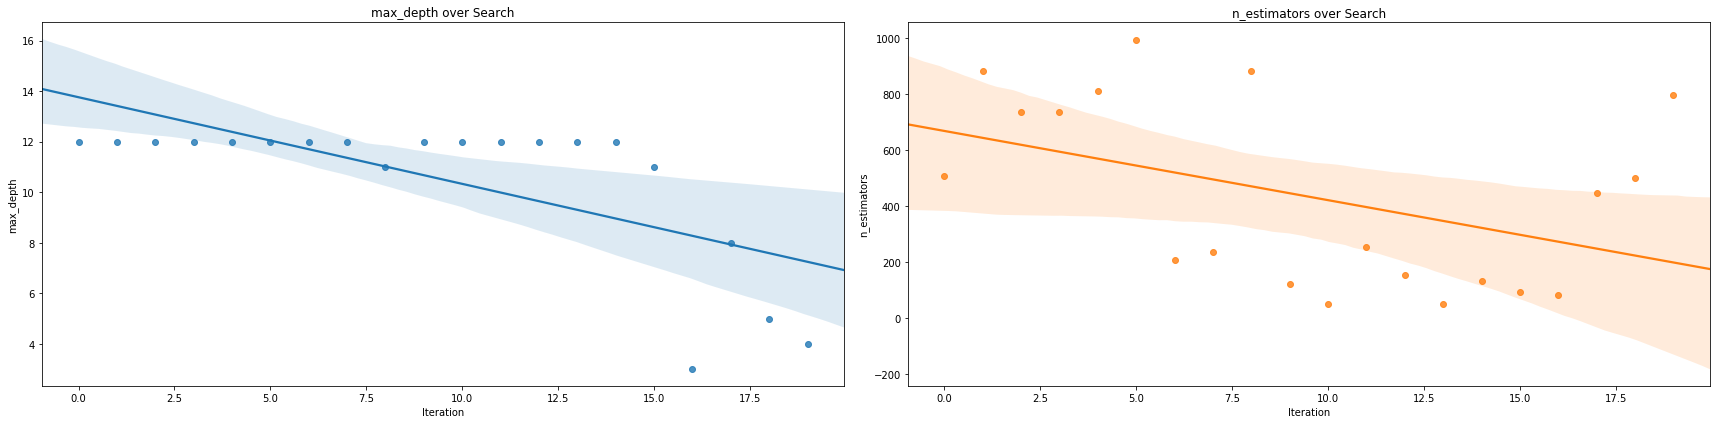

In [47]:
# Plot the value of hyperparameters over the tuning window
plt_hyper.plot_hyperparams_over_search(
    df=tuning_analysis, hyperparams=["max_depth", "n_estimators"]
)

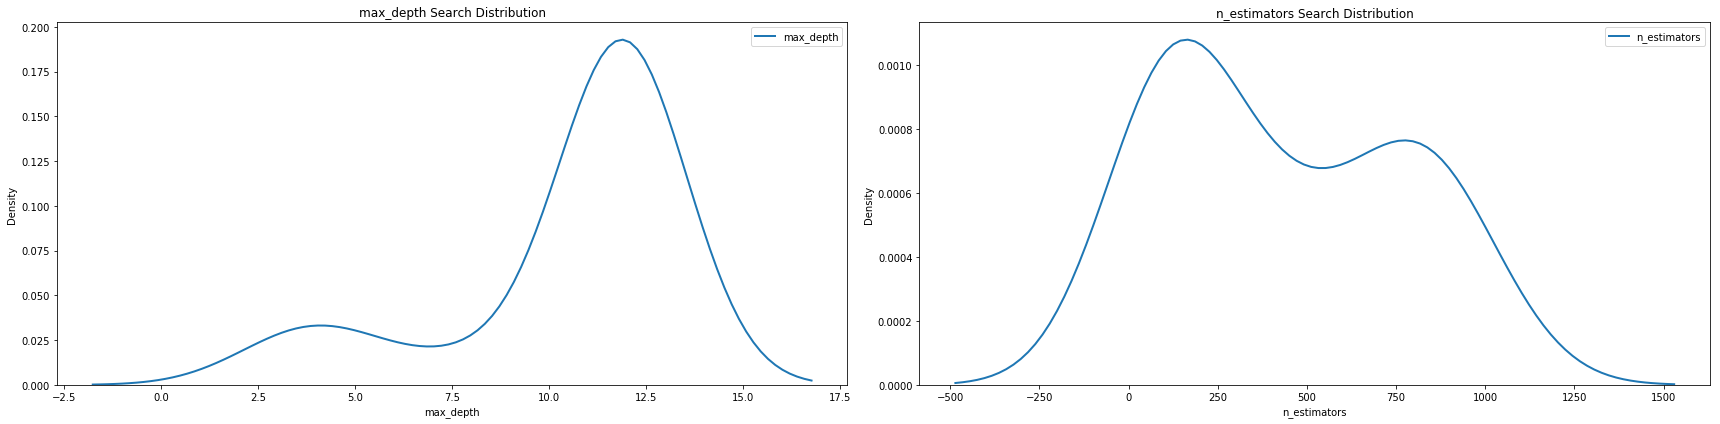

In [48]:
# Create a kde plot of hyperparameters used over the tuning window
plt_hyper.plot_search_dist(
    df=tuning_analysis, hyperparams=["max_depth", "n_estimators"]
)

#### Evaluate on the validation set

In [49]:
# Get the best hyperparameters and refit the model over the training data with the best params
tuning_analysis.sort_values(by=["FinalObjectiveValue"], ascending=False, axis=0, inplace=True)
max_depth = int(tuning_analysis["max_depth"].reset_index(drop=True)[0])
n_estimators = int(tuning_analysis["n_estimators"].reset_index(drop=True)[0])
max_features = tuning_analysis["max_features"].reset_index(drop=True)[0]

rf_model = SKLearn(
    entry_point="train_rf.py",
    train_instance_type="ml.m5.xlarge",
    hyperparameters={
        "n_estimators": n_estimators,
        "max_features": max_features,
        "max_depth": max_depth,
        "tune": 0,
    },
    role=role,
)

rf_model.fit({"train": preprocessed_training_data})
training_job_description = rf_model.jobs[-1].describe()
model_data_s3_uri = "{}{}/{}".format(
    training_job_description["OutputDataConfig"]["S3OutputPath"],
    training_job_description["TrainingJobName"],
    "output/model.tar.gz",
)

# Run the evaluation on the validation data
sklearn_processor.run(
    code="evaluation_sklearn.py",
    inputs=[
        ProcessingInput(
            source=model_data_s3_uri, destination="/opt/ml/processing/model"
        ),
        ProcessingInput(
            source=preprocessed_valid_data, destination="/opt/ml/processing/valid"
        ),
    ],
    outputs=[
        ProcessingOutput(
            output_name="evaluation", source="/opt/ml/processing/evaluation"
        )
    ],
)
evaluation_job_description = sklearn_processor.jobs[-1].describe()

evaluation_output_config = evaluation_job_description["ProcessingOutputConfig"]
for output in evaluation_output_config["Outputs"]:
    if output["OutputName"] == "evaluation":
        evaluation_s3_uri = output["S3Output"]["S3Uri"] + "/evaluation.json"
        break

evaluation_output = S3Downloader.read_file(evaluation_s3_uri)
evaluation_output_dict = json.loads(evaluation_output)
print(json.dumps(evaluation_output_dict, sort_keys=True, indent=4))

2020-03-23 01:11:58 Starting - Starting the training job...
2020-03-23 01:12:00 Starting - Launching requested ML instances...
2020-03-23 01:12:55 Starting - Preparing the instances for training......
2020-03-23 01:13:55 Downloading - Downloading input data
2020-03-23 01:13:55 Training - Downloading the training image..2020-03-23 01:14:10,089 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2020-03-23 01:14:10,091 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-03-23 01:14:10,100 sagemaker_sklearn_container.training INFO     Invoking user training script.
2020-03-23 01:14:10,322 sagemaker-containers INFO     Module train_rf does not provide a setup.py. 
Generating setup.py
2020-03-23 01:14:10,322 sagemaker-containers INFO     Generating setup.cfg
2020-03-23 01:14:10,323 sagemaker-containers INFO     Generating MANIFEST.in
2020-03-23 01:14:10,323 sagemaker-containers INFO     Installing module with the following comm

.................../miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/cloudpickle/cloudpickle.py:47: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
Extracting model from path: /opt/ml/processing/model/model.tar.gz
Loading model
Loading validation input data
Creating classification evaluation report
Classification report:
{'0.0': {'precision': 0.9517636624138637, 'recall': 0.9589606104351412, 'f1-score': 0.9553485823859746, 'support': 14547}, '1.0': {'precision': 0.9586593726196246, 'recall': 0.9514122740705107, 'f1-score': 0.9550220750551877, 'support': 14551}, 'micro avg': {'precision': 0.9551859234311637, 'recall': 0.9551859234311637, 'f1-score': 0.9551859234311637, 'support': 29098}, 'macro avg': {'precision': 0.9552115175167442, 'recall': 0.955186442252826, 'f1-score': 0.9551853287205812, 'support': 29098}, 'weighted avg': {'precision': 0.955211991481292, 'recall': 0.9

### Train, tune and evaluate XGBoost Model

#### Prepare data for Sagemaker XGBoost training

In [5]:
# Set up the training, test and validation data how the Sagemaker XGBoost model expects it and upload to S3
# so that Sagemaker can access it
data_dir = "./xgboost_out"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

X_train = pd.read_csv(preprocessed_training_data + "/train_features.csv", header=None)
Y_train = pd.read_csv(preprocessed_training_data + "/train_labels.csv", header=None)
X_test = pd.read_csv(preprocessed_test_data + "/test_features.csv", header=None)
Y_test = pd.read_csv(preprocessed_test_data + "/test_labels.csv", header=None)
X_val = pd.read_csv(preprocessed_valid_data + "/valid_features.csv", header=None)
Y_val = pd.read_csv(preprocessed_valid_data + "/valid_labels.csv", header=None)

prefix = "xgboost_tuning"
X_val.to_csv(os.path.join(data_dir, "validation.csv"), header=False, index=False)
pd.concat([Y_test, X_test], axis=1).to_csv(
    os.path.join(data_dir, "test.csv"), header=False, index=False
)
pd.concat([Y_train, X_train], axis=1).to_csv(
    os.path.join(data_dir, "train.csv"), header=False, index=False
)

test_location = session.upload_data(
    os.path.join(data_dir, "test.csv"), key_prefix=prefix
)
val_location = session.upload_data(
    os.path.join(data_dir, "validation.csv"), key_prefix=prefix
)
train_location = session.upload_data(
    os.path.join(data_dir, "train.csv"), key_prefix=prefix
)

#### Tune the hyperparameters

In [6]:
# Construct the xgboost estimator object
container = get_image_uri(session.boto_region_name, "xgboost", "0.90-1")
prefix = "xgboost"

xgb = sagemaker.estimator.Estimator(
    container,
    role,
    train_instance_count=1,
    train_instance_type="ml.m4.xlarge",
    output_path="s3://{}/{}/output".format(session.default_bucket(), prefix),
    sagemaker_session=session,
)

# Set up the hyperparameter tuning job for XGBoost
xgb.set_hyperparameters(
    objective="reg:logistic", early_stopping_rounds=10, num_round=200
)

xgb_hyperparameter_tuner = HyperparameterTuner(
    estimator=xgb,
    objective_metric_name="validation:auc",
    objective_type="Maximize",
    max_jobs=20,
    max_parallel_jobs=3,
    hyperparameter_ranges={
        "max_depth": IntegerParameter(3, 12),
        "eta": ContinuousParameter(0.05, 0.5),
        "min_child_weight": IntegerParameter(2, 8),
        "subsample": ContinuousParameter(0.5, 0.9),
        "gamma": ContinuousParameter(0, 10),
    },
)

# Tune the XGBoost model
s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type="csv")
s3_input_test = sagemaker.s3_input(s3_data=test_location, content_type="csv")

xgb_hyperparameter_tuner.fit({"train": s3_input_train, "validation": s3_input_test})
xgb_hyperparameter_tuner.wait()

# Attach the best training job
xgb_attached = sagemaker.estimator.Estimator.attach(
    xgb_hyperparameter_tuner.best_training_job()
)

# Get analysis on the tuning job including best hyperparameters
tuning_analysis = (
    xgb_hyperparameter_tuner.analytics()
    .dataframe()
    .sort_values(by=["TrainingStartTime"], ascending=False, axis=0)
)

tuning_analysis['iteration'] = tuning_analysis.index
tuning_analysis.sort_values(by=["FinalObjectiveValue"], ascending=False, axis=0, inplace=True)

..................................................................................................................................................................................................................................................................................................................!
2020-03-22 23:50:25 Starting - Preparing the instances for training
2020-03-22 23:50:25 Downloading - Downloading input data
2020-03-22 23:50:25 Training - Training image download completed. Training in progress.
2020-03-22 23:50:25 Uploading - Uploading generated training model
2020-03-22 23:50:25 Completed - Training job completedINFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter _tuning_objective_metric value validation:auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:logistic to Json.
Returning the value itself
INFO:sagemaker-

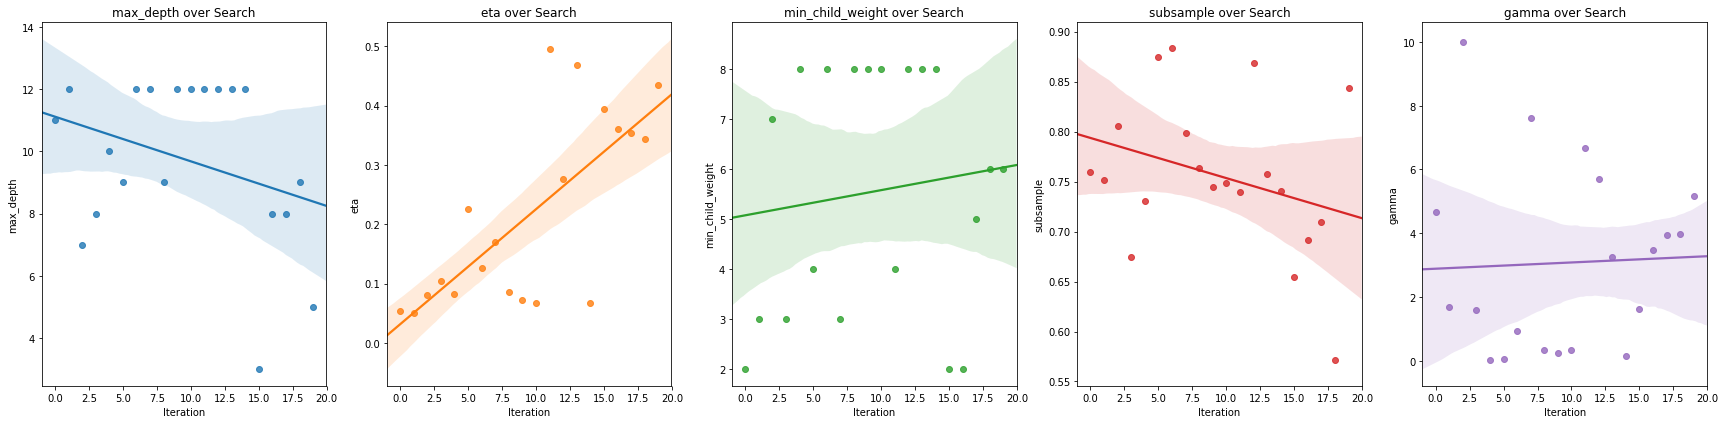

In [7]:
# Plot the value of hyperparameters over the tuning window
plt_hyper.plot_hyperparams_over_search(
    df=tuning_analysis,
    hyperparams=["max_depth", "eta", "min_child_weight", "subsample", "gamma"],
)

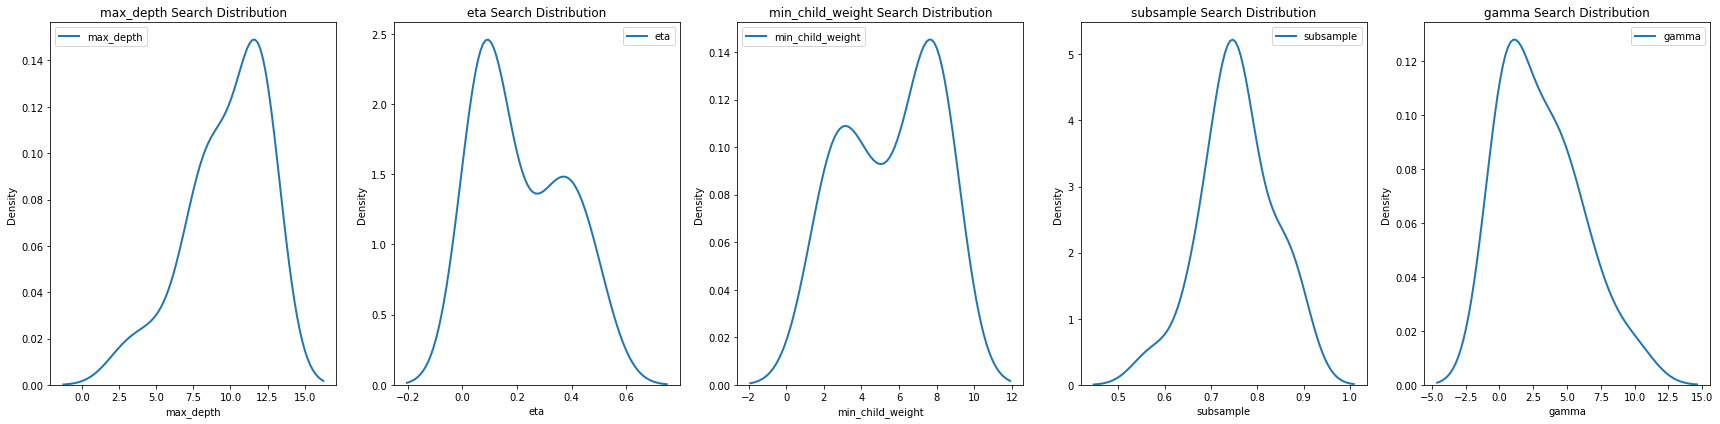

In [8]:
# Create a kde plot of hyperparameters used over the tuning window
plt_hyper.plot_search_dist(
    df=tuning_analysis,
    hyperparams=["max_depth", "eta", "min_child_weight", "subsample", "gamma"],
)

#### Evaluate on the validation set 

In [37]:
# Evaluate the XGBoost model on the validation data
XGBoost_eval.evaluate_xgboost(
    tuned_model=xgb_attached,
    val_data_location=val_location,
    pred_out=data_dir,
    proba_cutoff=0.5,
    Y_val=Y_val,
)

......................[2020-02-10 01:42:18 +0000] [15] [INFO] Starting gunicorn 19.10.0
[2020-02-10 01:42:18 +0000] [15] [INFO] Listening at: unix:/tmp/gunicorn.sock (15)
[2020-02-10 01:42:18 +0000] [15] [INFO] Using worker: gevent
[2020-02-10 01:42:18 +0000] [22] [INFO] Booting worker with pid: 22
[2020-02-10 01:42:18 +0000] [23] [INFO] Booting worker with pid: 23
[2020-02-10 01:42:18 +0000] [24] [INFO] Booting worker with pid: 24
[2020-02-10 01:42:18 +0000] [28] [INFO] Booting worker with pid: 28
[2020-02-10:01:42:23:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [10/Feb/2020:01:42:23 +0000] "GET /ping HTTP/1.1" 200 0 "-" "Go-http-client/1.1"
169.254.255.130 - - [10/Feb/2020:01:42:23 +0000] "GET /execution-parameters HTTP/1.1" 200 84 "-" "Go-http-client/1.1"
[2020-02-10:01:42:23:INFO] No GPUs detected (normal if no gpus installed)
[2020-02-10:01:42:24:INFO] No GPUs detected (normal if no gpus installed)
[2020-02-10:01:42:24:INFO] Determined delimiter of CSV 